<a href="https://colab.research.google.com/github/Vakhranev/MDB/blob/main/Boxplots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Лемматизация и присвоение частей речи

In [1]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=3e5929b2fcc9c183588ef2020c04448b08cd50584b88c2a8649c28167e1538c8
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymorphy2
import re
import glob

# Загрузка данных Ляшевской
df_lyashevskaya = pd.read_csv('freqrnc2011.csv', sep='\t')
df_lyashevskaya['Lemma'] = df_lyashevskaya['Lemma'].str.lower()

# Создание словаря соответствий тегов частей речи
pos_mapping = {
    'NOUN': 's',
    'VERB': 'v',
    'ADJF': 'a',
    'ADJS': 'a',
    'COMP': 'a',
    'INFN': 'v',
    'PRTF': 'v',
    'PRTS': 'v',
    'GRND': 'v',
    'NUMR': 'num',
    'ADVB': 'adv',
    'NPRO': 'spro',
    'PRED': 'adv',
    'PREP': 'pr',
    'CONJ': 'conj',
    'PRCL': 'part',
    'INTJ': 'intj'
}

# Создаем экземпляр морфологического анализатора pymorphy2
morph_analyzer = pymorphy2.MorphAnalyzer()

# Функция для лемматизации текста с сохранением части речи
def lemmatize_text(text):
    text = re.sub(r'[^а-яА-Я\s]', '', text)  # Удаление всех символов, кроме букв кириллицы и пробелов
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    lemmas_pos = [(morph_analyzer.parse(word)[0].normal_form, morph_analyzer.parse(word)[0].tag.POS) for word in words if word.strip()]
    return lemmas_pos

# Функция для обработки папки с текстами студентов
def process_folder(folder_path):
    unique_lemmas_by_level = {}
    for file_path in glob.glob(folder_path + "/*.txt"):
        with open(file_path, "r", encoding='utf-8') as file:
            text = file.read()
            lemmas_pos = lemmatize_text(text)
            unique_lemmas_pos = list(set(lemmas_pos))  # Удаление неуникальных лемм
            unique_lemmas_by_level[file_path] = unique_lemmas_pos
    return unique_lemmas_by_level

# Пример обработки первой работы из уровня A1
students_path = 'Students_texts/A1'
student_lemmas = process_folder(students_path)
print(f"Пример лемматизации и POS-тегов первой работы из A1: {list(student_lemmas.values())[0][:10]}")

# Добавление поля rank в словарь Ляшевской
df_lyashevskaya = df_lyashevskaya.sort_values(by='Freq(ipm)', ascending=False)
df_lyashevskaya['Rank'] = df_lyashevskaya['Freq(ipm)'].rank(method='max', ascending=False)

# Присвоение рангов для лемм студентов
def assign_ranks(lemmas_pos, df_lyashevskaya, pos_mapping):
    ranks = []
    for lemma, pos in lemmas_pos:
        mapped_pos = pos_mapping.get(pos, None)
        if mapped_pos:
            rank = df_lyashevskaya[(df_lyashevskaya['Lemma'] == lemma) & (df_lyashevskaya['PoS'] == mapped_pos)]['Rank']
            if not rank.empty:
                ranks.append(rank.values[0])
            else:
                ranks.append(float('inf'))  # Для лемм, которых нет в словаре, присваиваем бесконечный ранг
        else:
            ranks.append(float('inf'))
    return ranks

# Функция для расчета MRR для студентов
def calculate_mrr(ranks):
    if len(ranks) == 0:
        return 0
    return np.mean([1.0 / rank if rank != float('inf') else 0 for rank in ranks])

# Подсчет рангов и MRR для первой работы из уровня A1
for file, lemmas_pos in student_lemmas.items():
    ranks = assign_ranks(lemmas_pos, df_lyashevskaya, pos_mapping)
    mrr = calculate_mrr(ranks)
    print(f"Ранговое распределение для первой работы из A1: {ranks[:10]}")
    print(f"MRR для первой работы из A1: {mrr}")
    break

Пример лемматизации и POS-тегов первой работы из A1: [('мой', 'ADJF'), ('два', 'NUMR'), ('бонить', 'GRND'), ('знать', 'VERB'), ('натеианалность', 'NOUN'), ('катушить', 'GRND'), ('порусски', 'ADVB'), ('дело', 'NOUN'), ('немного', 'ADVB'), ('эля', 'NOUN')]
Ранговое распределение для первой работы из A1: [inf, 70.0, inf, 61.0, inf, inf, inf, 65.0, 782.0, inf]
MRR для первой работы из A1: 0.025465638617665803


Проверка размера выборок

In [26]:
# Подготовка файлов топа, низа и случайных слов из словаря Ляшевской
top_lemmas = df_lyashevskaya.head(25)['Lemma'].tolist()
bottom_lemmas = df_lyashevskaya.tail(25)['Lemma'].tolist()
random_lemmas = df_lyashevskaya.sample(25)['Lemma'].tolist()

with open('top_lemmas.txt', 'w', encoding='utf-8') as f:
    for lemma in top_lemmas:
        f.write(f"{lemma}\n")

with open('bottom_lemmas.txt', 'w', encoding='utf-8') as f:
    for lemma in bottom_lemmas:
        f.write(f"{lemma}\n")

with open('random_lemmas.txt', 'w', encoding='utf-8') as f:
    for lemma in random_lemmas:
        f.write(f"{lemma}\n")

print("Файлы топа, низа и случайных слов созданы.")
print(f"Размер топ-лемм: {len(top_lemmas)}")
print(f"Размер нижних лемм: {len(bottom_lemmas)}")
print(f"Размер случайных лемм: {len(random_lemmas)}")

Файлы топа, низа и случайных слов созданы.
Размер топ-лемм: 25
Размер нижних лемм: 25
Размер случайных лемм: 25


Расчет MRR для топа, низа и случайных лемм

In [27]:
# Расчет MRR для групп лемм
def calculate_mrr_lemmas(lemmas, df_lyashevskaya):
    ranks = []
    for lemma in lemmas:
        rank = df_lyashevskaya[df_lyashevskaya['Lemma'] == lemma]['Rank']
        if not rank.empty:
            ranks.append(rank.values[0])
        else:
            ranks.append(float('inf'))  # Для лемм, которых нет в словаре, присваиваем бесконечный ранг
    return np.mean([1.0 / rank if rank != float('inf') else 0 for rank in ranks])

# Загрузка лемм из файлов
def load_lemmas_from_file(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        lemmas = [line.strip() for line in file.readlines()]
    return lemmas

top_lemmas = load_lemmas_from_file('top_lemmas.txt')
bottom_lemmas = load_lemmas_from_file('bottom_lemmas.txt')
random_lemmas = load_lemmas_from_file('random_lemmas.txt')

# Расчет MRR для групп лемм
mrr_top = calculate_mrr_lemmas(top_lemmas, df_lyashevskaya)
mrr_bottom = calculate_mrr_lemmas(bottom_lemmas, df_lyashevskaya)
mrr_random = calculate_mrr_lemmas(random_lemmas, df_lyashevskaya)

# Вывод MRR для проверки
print(f"MRR для топ-лемм: {mrr_top}")
print(f"MRR для нижних лемм: {mrr_bottom}")
print(f"MRR для случайных лемм: {mrr_random}")

MRR для топ-лемм: 0.15263832711014028
MRR для нижних лемм: 1.9179868809697343e-05
MRR для случайных лемм: 0.00010075793917919536


Визуализация результатов MRR

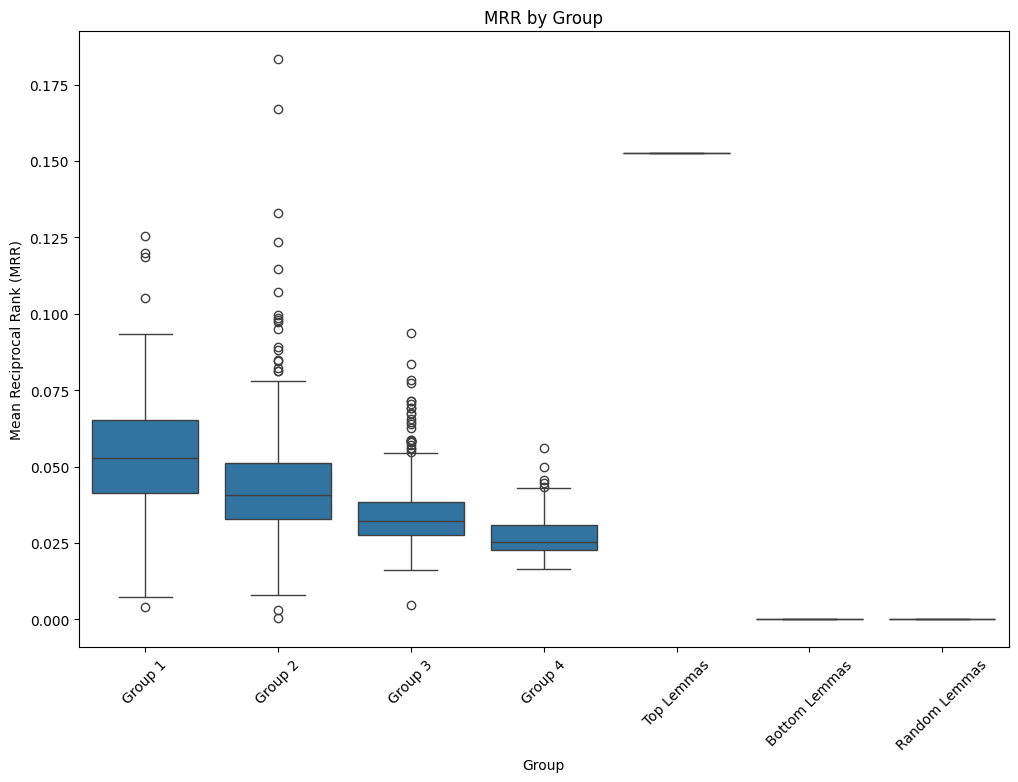

In [28]:
# Объединение данных и создание единого графика
# Создание DataFrame для визуализации по уровням студентов
mrr_data_students = []
for level, mrr_list in mrr_scores.items():
    for mrr in mrr_list:
        mrr_data_students.append({'Group': level, 'MRR': mrr})

df_mrr_students = pd.DataFrame(mrr_data_students)
df_mrr_students['Group'] = df_mrr_students['Group'].replace({'A1': 'Group 1', 'A2': 'Group 2', 'B1': 'Group 3', 'B2': 'Group 4'})

# Создание DataFrame для визуализации по группам лемм
mrr_data_lemmas = [
    {'Group': 'Top Lemmas', 'MRR': mrr_top},
    {'Group': 'Bottom Lemmas', 'MRR': mrr_bottom},
    {'Group': 'Random Lemmas', 'MRR': mrr_random}
]

df_mrr_lemmas = pd.DataFrame(mrr_data_lemmas)

# Объединение двух DataFrame
df_mrr_combined = pd.concat([df_mrr_students, df_mrr_lemmas], ignore_index=True)

# Визуализация с использованием boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Group', y='MRR', data=df_mrr_combined)
plt.title('MRR by Group')
plt.ylabel('Mean Reciprocal Rank (MRR)')
plt.xlabel('Group')
plt.xticks(rotation=45)
plt.show()

Расчет и визуализация Freq(ipm)

Частотное распределение для первой работы из A1: [0, 1285.1, 0, 1713.8, 0, 0, 0, 1412.1, 151.9, 0]
Средний Freq(ipm) для первой работы из A1: 1805.8976190476194


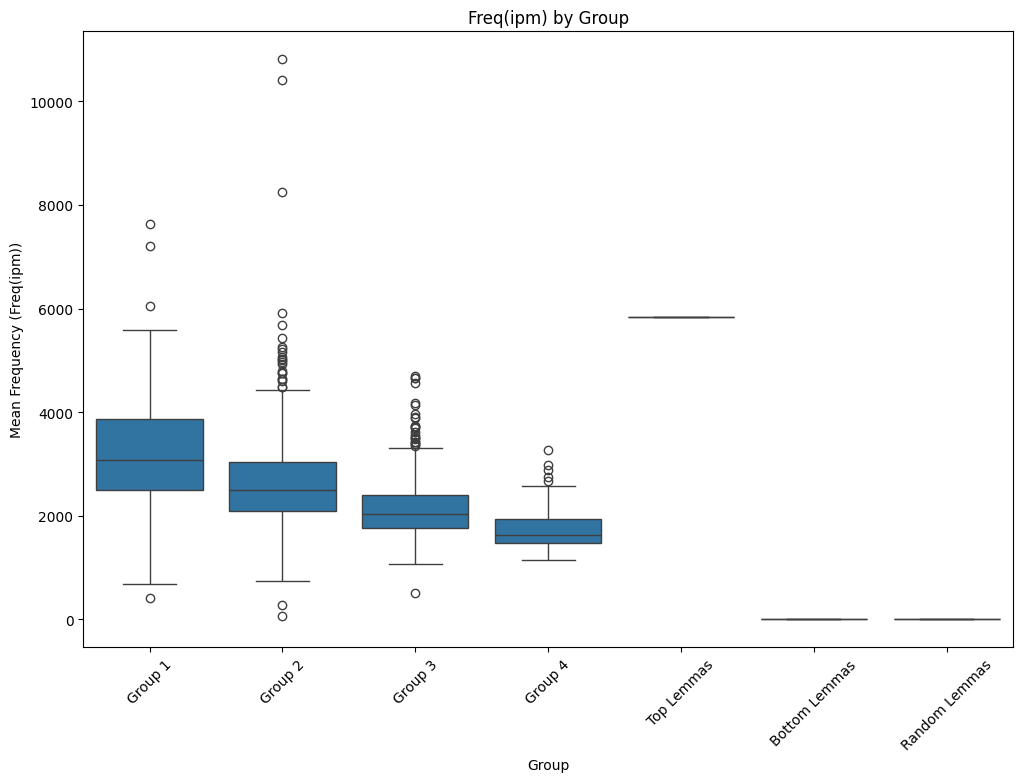

In [29]:
# Присвоение частот для лемм студентов
def assign_freq(lemmas_pos, df_lyashevskaya, pos_mapping):
    freqs = []
    for lemma, pos in lemmas_pos:
        mapped_pos = pos_mapping.get(pos, None)
        if mapped_pos:
            freq = df_lyashevskaya[(df_lyashevskaya['Lemma'] == lemma) & (df_lyashevskaya['PoS'] == mapped_pos)]['Freq(ipm)']
            if not freq.empty:
                freqs.append(freq.values[0])
            else:
                freqs.append(0)
        else:
            freqs.append(0)
    return freqs

# Функция для расчета среднего Freq(ipm) для студентов
def calculate_mean_freq(freqs):
    if len(freqs) == 0:
        return 0
    return np.mean(freqs)

# Подсчет частот и среднего Freq(ipm) для первой работы из уровня A1
for file, lemmas_pos in student_lemmas.items():
    freqs = assign_freq(lemmas_pos, df_lyashevskaya, pos_mapping)
    mean_freq = calculate_mean_freq(freqs)
    print(f"Частотное распределение для первой работы из A1: {freqs[:10]}")
    print(f"Средний Freq(ipm) для первой работы из A1: {mean_freq}")
    break

# Подготовка данных для визуализации Freq(ipm)
freq_data_students = []
for level, freqs in freq_scores.items():
    for score in freqs:
        freq_data_students.append({'Group': level, 'Freq(ipm)': score})

df_freq_students = pd.DataFrame(freq_data_students)

# Переименование уровней для визуализации
df_freq_students['Group'] = df_freq_students['Group'].replace({'A1': 'Group 1', 'A2': 'Group 2', 'B1': 'Group 3', 'B2': 'Group 4'})

# Создание DataFrame для визуализации по группам лемм
freq_data_lemmas = [
    {'Group': 'Top Lemmas', 'Freq(ipm)': np.mean(df_lyashevskaya[df_lyashevskaya['Lemma'].isin(top_lemmas)]['Freq(ipm)'])},
    {'Group': 'Bottom Lemmas', 'Freq(ipm)': np.mean(df_lyashevskaya[df_lyashevskaya['Lemma'].isin(bottom_lemmas)]['Freq(ipm)'])},
    {'Group': 'Random Lemmas', 'Freq(ipm)': np.mean(df_lyashevskaya[df_lyashevskaya['Lemma'].isin(random_lemmas)]['Freq(ipm)'])}
]

df_freq_lemmas = pd.DataFrame(freq_data_lemmas)

# Объединение двух DataFrame
df_freq_combined = pd.concat([df_freq_students, df_freq_lemmas], ignore_index=True)

# Визуализация с использованием boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Group', y='Freq(ipm)', data=df_freq_combined)
plt.title('Freq(ipm) by Group')
plt.ylabel('Mean Frequency (Freq(ipm))')
plt.xlabel('Group')
plt.xticks(rotation=45)
plt.show()